<a href="https://colab.research.google.com/github/Priyanshuraj74/ADVANCED-PREDICTIVE-MAINTENANCE-MODEL/blob/main/ADVANCED_PREDICTIVE_MAINTENANCE_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['predictive_maintenance.csv']))
print(df.head())

Saving predictive_maintenance.csv to predictive_maintenance.csv
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  


✅ Cleaned Columns:
 ['UDI', 'Product_ID', 'Type', 'Air_temperature__K_', 'Process_temperature__K_', 'Rotational_speed__rpm_', 'Torque__Nm_', 'Tool_wear__min_', 'Target', 'Failure_Type'] 

Sample Data:
    UDI Product_ID Type  Air_temperature__K_  Process_temperature__K_  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational_speed__rpm_  Torque__Nm_  Tool_wear__min_  Target Failure_Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5           

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:34:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Accuracy: 98.75%
🏁 ROC-AUC: 0.979

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.81      0.82      0.82        68

    accuracy                           0.99      2000
   macro avg       0.90      0.91      0.91      2000
weighted avg       0.99      0.99      0.99      2000



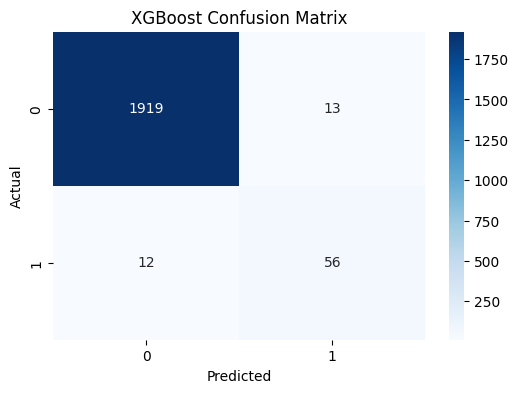

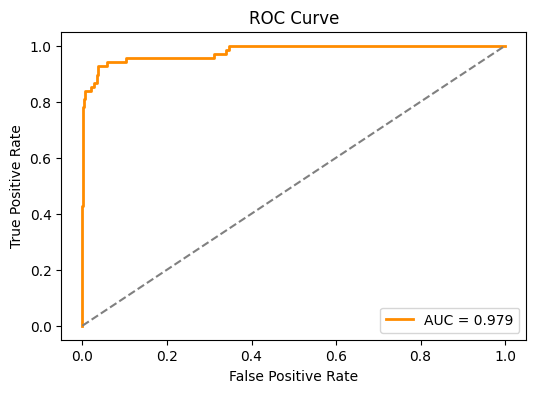

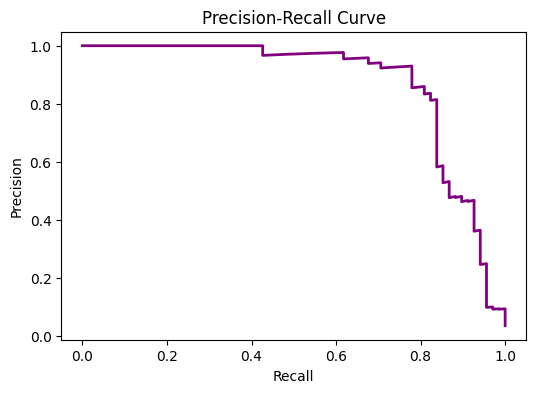

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


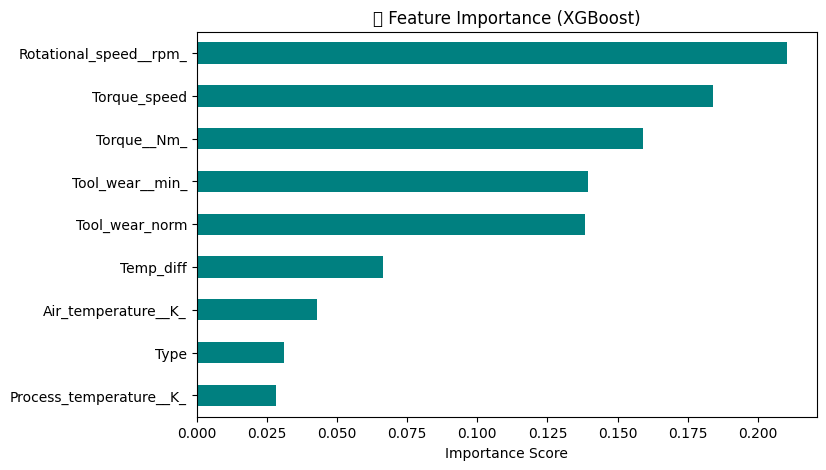


🔧 Enter engine details for prediction:
Engine Type (M=Medium, L=Light, H=Heavy): M
Air Temperature inside engine (K, e.g., 298): 300
Engine Process Temperature (K, e.g., 308): 308
Engine Speed (Low/Medium/High): Low
Engine Load (Low/Medium/High): Medium
Engine Usage Hours (e.g., 0-20): 15

⚠️ Prediction: Engine Failure Likely! (Probability: 0.92)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
)
from xgboost import XGBClassifier
import shap



file_path = "predictive_maintenance.csv"
df = pd.read_csv(file_path)


df.columns = df.columns.str.replace(r"\[|\]| ", "_", regex=True)
print("✅ Cleaned Columns:\n", df.columns.tolist(), "\n")
print("Sample Data:\n", df.head())



le_type = LabelEncoder()
le_failure = LabelEncoder()

df["Type"] = le_type.fit_transform(df["Type"])
df["Failure_Type"] = le_failure.fit_transform(df["Failure_Type"])




df['Temp_diff'] = df['Air_temperature__K_'] - df['Process_temperature__K_']
df['Torque_speed'] = df['Torque__Nm_'] * df['Rotational_speed__rpm_']
df['Tool_wear_norm'] = df['Tool_wear__min_'] / df['Tool_wear__min_'].max()


feature_cols = [
    'Type', 'Air_temperature__K_', 'Process_temperature__K_',
    'Rotational_speed__rpm_', 'Torque__Nm_', 'Tool_wear__min_',
    'Temp_diff', 'Torque_speed', 'Tool_wear_norm'
]
target_col = 'Target'

X = df[feature_cols]
y = df[target_col]


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols)



X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")



xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)



y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]


acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n✅ Accuracy: {acc*100:.2f}%")
print(f"🏁 ROC-AUC: {auc:.3f}")


print("\nClassification Report:\n", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", color='darkorange', lw=2)
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()



importances = pd.Series(xgb_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8,5))
importances.plot(kind='barh', color='teal')
plt.title("🔥 Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()


def user_friendly_prediction(model, scaler, feature_cols):
    print("\n🔧 Enter engine details for prediction:")


    engine_type = input("Engine Type (M=Medium, L=Light, H=Heavy): ").upper()
    type_map = {label: idx for idx, label in enumerate(le_type.classes_)}
    if engine_type not in type_map:
        print("⚠️ Invalid type. Defaulting to 'M'.")
        type_input_encoded = type_map['M']
    else:
        type_input_encoded = type_map[engine_type]


    try:
        air_temp = float(input("Air Temperature inside engine (K, e.g., 298): "))
        process_temp = float(input("Engine Process Temperature (K, e.g., 308): "))
    except ValueError:
        print("⚠️ Invalid input. Using default temperatures 298K/308K.")
        air_temp, process_temp = 298, 308


    speed_input = input("Engine Speed (Low/Medium/High): ").lower()
    speed_map = {"low": 1300, "medium": 1500, "high": 1700}
    rotational_speed = speed_map.get(speed_input, 1500)


    load_input = input("Engine Load (Low/Medium/High): ").lower()
    load_map = {"low": 40, "medium": 50, "high": 60}
    torque = load_map.get(load_input, 50)


    try:
        usage_hours = float(input("Engine Usage Hours (e.g., 0-20): "))
    except ValueError:
        print("⚠️ Invalid input. Using 5 hours as default.")
        usage_hours = 5
    tool_wear = usage_hours


    temp_diff = air_temp - process_temp
    torque_speed = torque * rotational_speed
    tool_wear_norm = tool_wear / df['Tool_wear__min_'].max()


    input_array = np.array([[
        type_input_encoded, air_temp, process_temp,
        rotational_speed, torque, tool_wear,
        temp_diff, torque_speed, tool_wear_norm
    ]])


    input_scaled = scaler.transform(input_array)


    pred = model.predict(input_scaled)[0]
    pred_proba = model.predict_proba(input_scaled)[0][1]


    if pred == 1:
        print(f"\n⚠️ Prediction: Engine Failure Likely! (Probability: {pred_proba:.2f})")
    else:
        print(f"\n✅ Prediction: Engine Normal. (Probability of failure: {pred_proba:.2f})")


user_friendly_prediction(xgb_model, scaler, feature_cols)



